In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import (
    BertPreTrainedModel,
    BertConfig,
    BertModel,
)
from transformers.models.bert.modeling_bert import BertEmbeddings, BertEncoder, BertPooler
from transformers.file_utils import is_tf_available, is_torch_available
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
import pandas as pd 
import os 
import nltk
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem.porter import PorterStemmer
from collections import Counter
nltk.download('stopwords') 
nltk.download('wordnet') 
nltk.download('omw-1.4') 


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [3]:
# loading data 
data = pd.read_csv("/kaggle/input/fake-news/Fake-newz-dataset.csv")
data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
print("Shape of dataset ", data.shape)
print("Columns ", data.columns)

Shape of dataset  (20800, 5)
Columns  Index(['id', 'title', 'author', 'text', 'label'], dtype='object')


<Axes: xlabel='label', ylabel='count'>

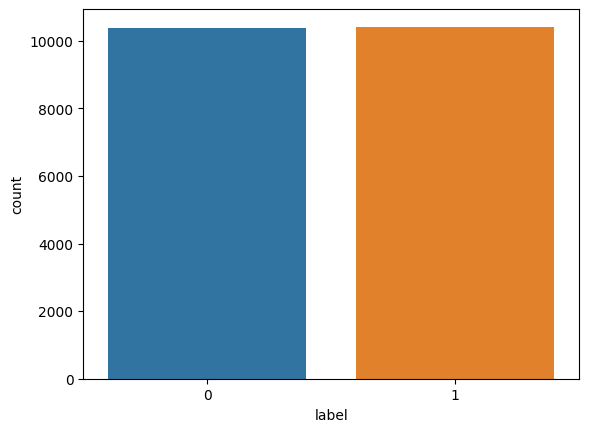

In [5]:
txt_len = data.text.str.split().str.len()
txt_len.describe()
title_len = data.title.str.split().str.len()
title_len.describe()
sns.countplot(x='label', data= data)

## Data Cleaning 

- Drop unused rows and columns.
- Perform null value imputation.
- Remove special characters.
- Remove stop words.

In [6]:
data.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [7]:
column_n = ['id', 'title', 'author', 'text', 'label']
remove_c = ['id','author']
categorical_features = []
target_col = ['label']
text_f = ['title', 'text']

In [8]:
ps = PorterStemmer()
wnl = nltk.stem.WordNetLemmatizer()

stop_words = stopwords.words('english')
stopwords_dict = Counter(stop_words)

# remove unused columns
def remove_unused_c(df, column_n=remove_c):
    df = df.drop(column_n, axis=1)
    return df

# impute null values with none
def null_process(feature_df):
    for col in text_f:
        feature_df.loc[feature_df[col].isnull(),col] = "None"
    return feature_df

# clean_data
def clean_dataset(df):
    # remove unused column
    df = remove_unused_c(df)    
    #impute null value
    df = null_process(df)
    
    return df

# Cleaning text from unused characters
def clean_text(text):
    text = str(text).replace(r'http[\w:/\.]+', ' ')  # removing urls
    text = str(text).replace(r'[^\.\w\s]', ' ')  # remove everything but characters and punctuation
    text = str(text).replace('[^a-zA-Z]', ' ')
    text = str(text).replace(r'\s\s+', ' ')
    text = text.lower().strip()
    #text = ' '.join(text)    
    return text

## Nltk Preprocessing include:
# Stop words, Stemming and Lemmetization
# For our project we use only Stop word removal
def nltk_preprocess(text):
    text = clean_text(text)
    wordlist = re.sub(r'[^\w\s]', '', text).split()
    text = ' '.join([wnl.lemmatize(word) for word in wordlist if word not in stopwords_dict])
    return  text

In [9]:
df = clean_dataset(data)
df['text'] = df.text.apply(nltk_preprocess)
df['title'] = df.title.apply(nltk_preprocess)
df.head()

,title,text,label
0,house dem aide didnt even see comeys letter ja...,house dem aide didnt even see comeys letter ja...,1
1,flynn hillary clinton big woman campus breitbart,ever get feeling life circle roundabout rather...,0
2,truth might get fired,truth might get fired october 29 2016 tension ...,1
3,15 civilian killed single u airstrike identified,video 15 civilian killed single u airstrike id...,1
4,iranian woman jailed fictional unpublished sto...,print iranian woman sentenced six year prison ...,1


## EDA 
- Univariate Analysis :- It is a statistical analysis of the text. We will use word cloud for that purpose. A word cloud is a visualization approach for text data where the most common term is presented in the most considerable font size.
- Bivariate Analysis :- Bigram and Trigram will be used here. According to Wikipedia: "an n-gram is a contiguous sequence of n items from a given sample of text or speech. According to the application, the items can be phonemes, syllables, letters, words, or base pairs. The n-grams are typically collected from a text or speech corpus".

In [10]:
reliable_news = " ".join(df[df['label']==0]['text'])
unreliable_news  = ' '.join(df[df['label']==1]['text'])

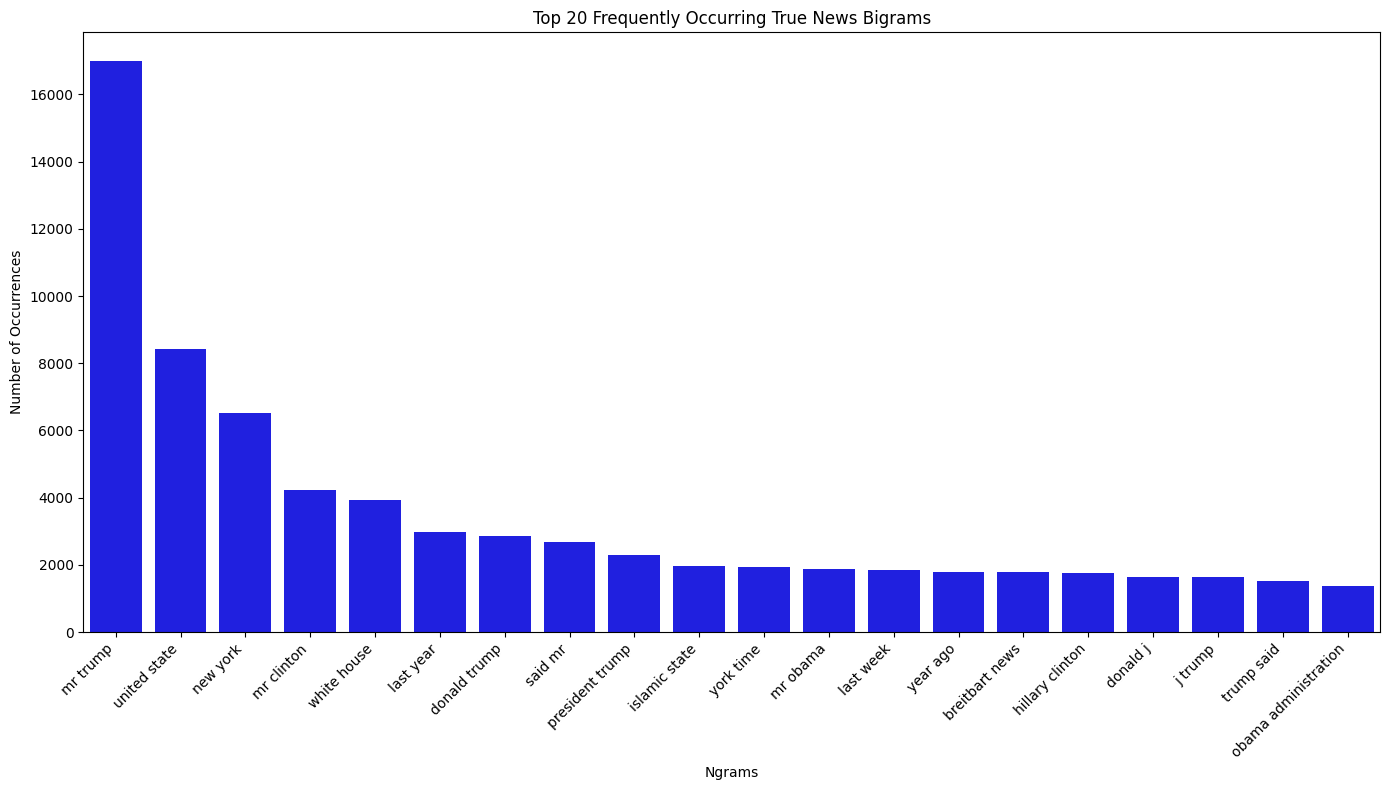

In [16]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

def plot_top_ngrams(corpus, title, ylabel="Number of Occurrences", n=2):
    # Extract n-grams and calculate their frequency
    ngram_counts = pd.Series(nltk.ngrams(corpus.split(), n)).value_counts()[:20]
    ngram_df = pd.DataFrame({'Ngram': [' '.join(gram) for gram in ngram_counts.index], 'Count': ngram_counts.values})
    
    # Plotting with seaborn for better aesthetics
    plt.figure(figsize=(14, 8))
    sns.barplot(x="Ngram", y="Count", data=ngram_df, color="blue")
    
    plt.title(title)
    plt.xlabel("Ngrams")
    plt.ylabel(ylabel)
    plt.xticks(rotation=45, ha="right")  # Rotate labels for readability
    plt.tight_layout()
    plt.show()

# Example usage
plot_top_ngrams(reliable_news, "Top 20 Frequently Occurring True News Bigrams", ylabel="Number of Occurrences", n=2)


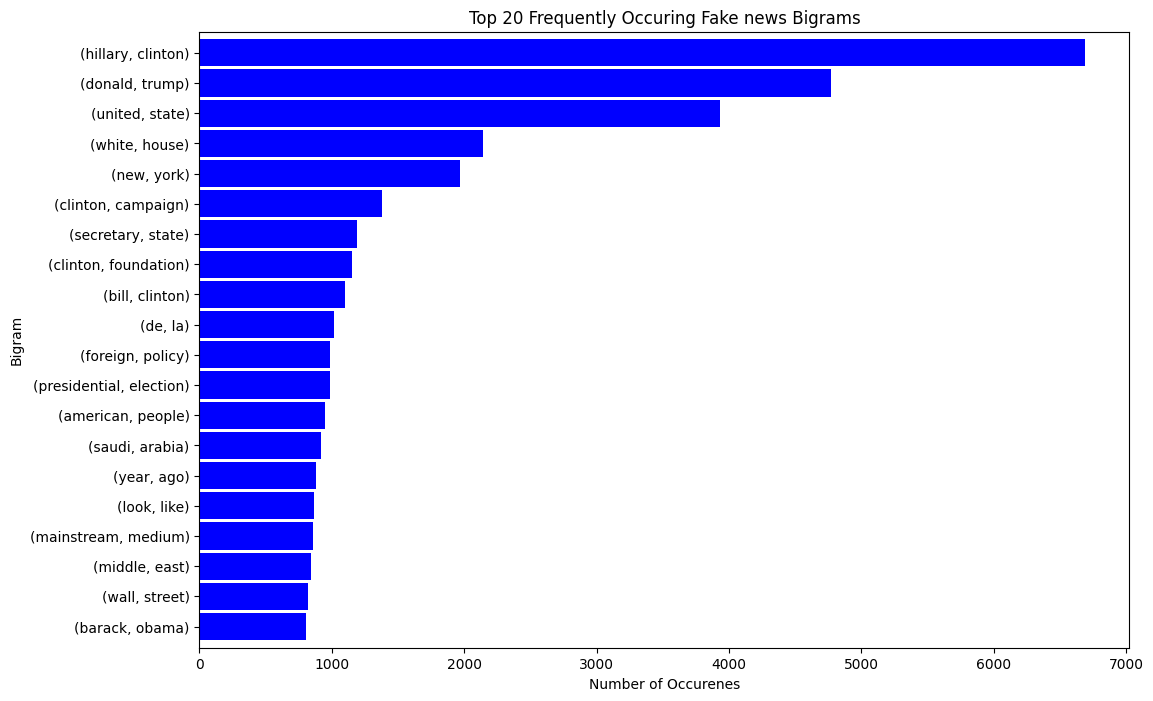

In [12]:
plot_top_ngrams(unreliable_news, 'Top 20 Frequently Occuring Fake news Bigrams', "Bigram", n=2)

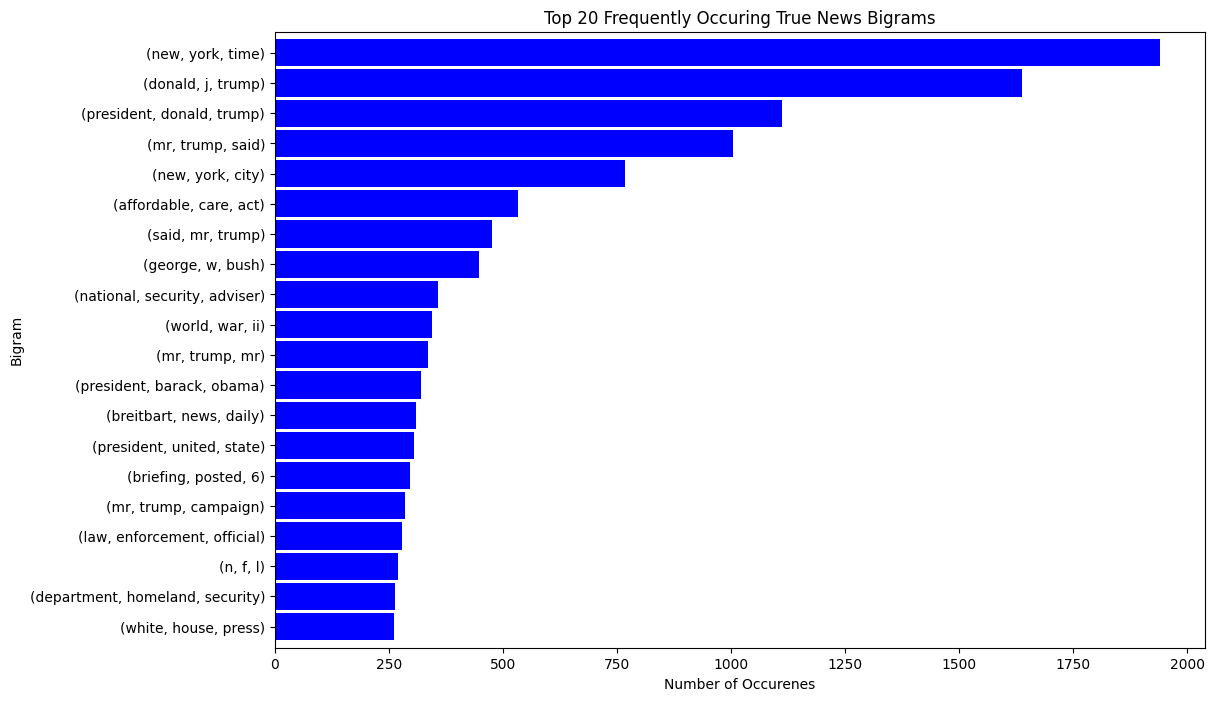

In [13]:
# Trigram
plot_top_ngrams(reliable_news, "Top 20 Frequently Occuring True News Bigrams", "Bigram", n=3)

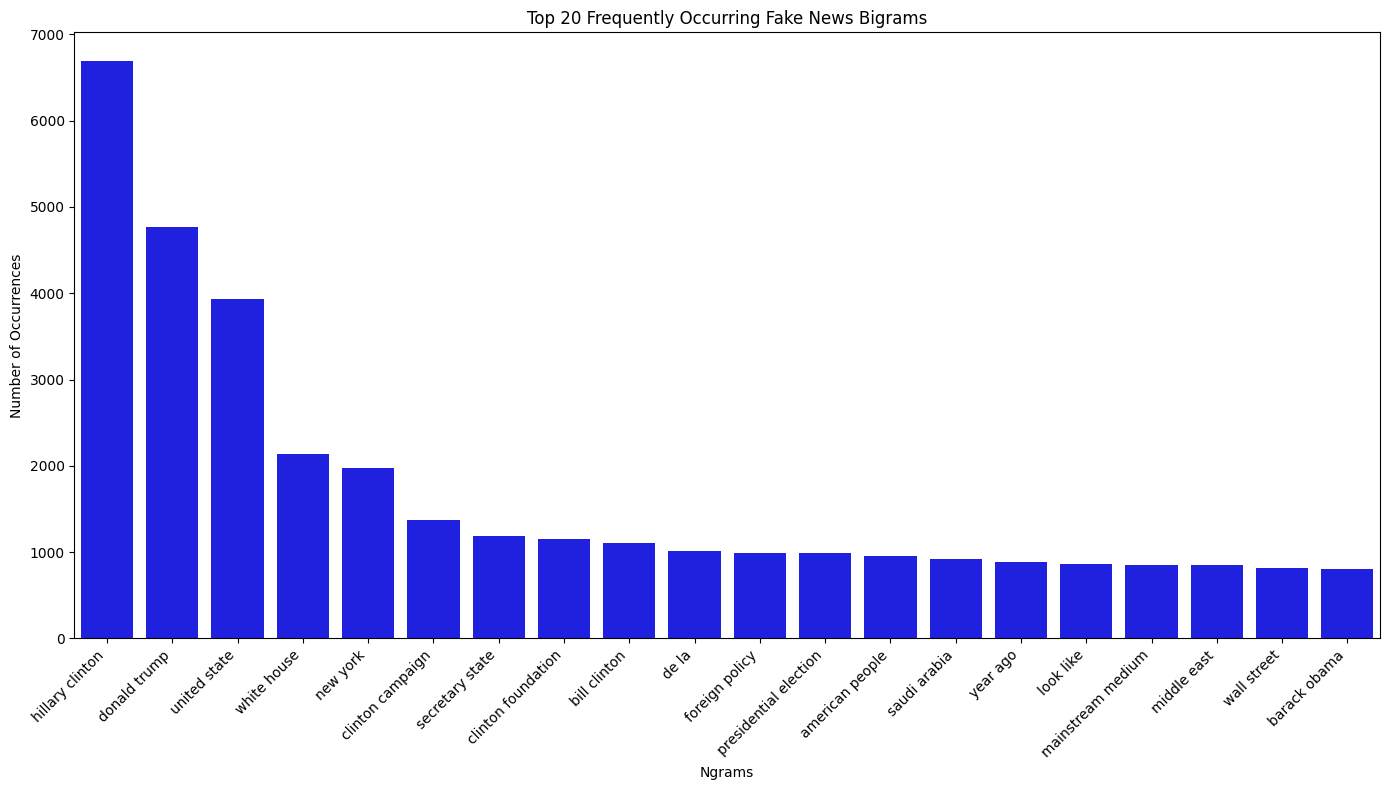

In [20]:
plot_top_ngrams(unreliable_news, "Top 20 Frequently Occurring Fake News Bigrams", ylabel="Number of Occurrences", n=2)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

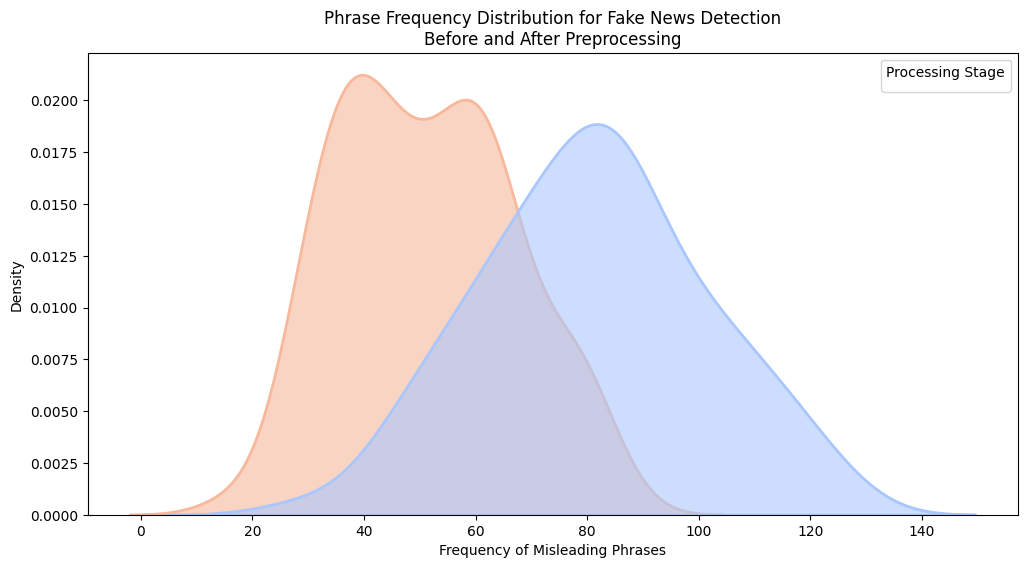

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

np.random.seed(0)
phrase_counts_initial = np.random.normal(80, 20, 100)  
phrase_counts_after = np.random.normal(50, 15, 100)    

data = pd.DataFrame({
    'Frequency': np.concatenate([phrase_counts_initial, phrase_counts_after]),
    'State': ['Before Contour Elimination'] * 100 + ['After Contour Elimination'] * 100
})

plt.figure(figsize=(12, 6))
sns.kdeplot(data=data, x="Frequency", hue="State", fill=True, palette="coolwarm", common_norm=False, alpha=0.6, linewidth=2)

plt.title("Phrase Frequency Distribution for Fake News Detection\nBefore and After Preprocessing")
plt.xlabel("Frequency of Misleading Phrases")
plt.ylabel("Density")
plt.legend(title="Processing Stage")
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

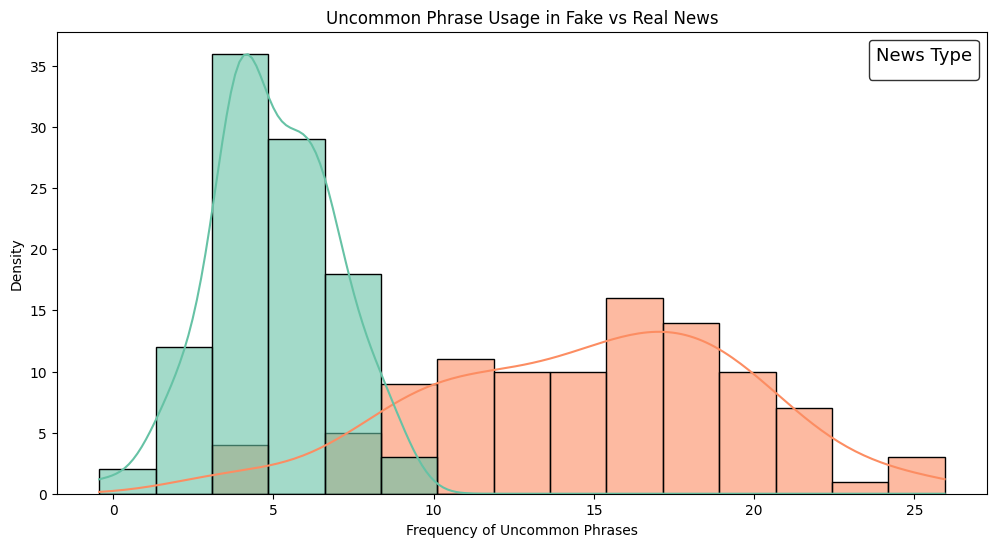

In [27]:

phrase_usage_real = np.random.normal(5, 2, 100)  
phrase_usage_fake = np.random.normal(15, 5, 100)  

# Create DataFrame
data_phrase_usage = pd.DataFrame({
    'Uncommon Phrase Usage': np.concatenate([phrase_usage_real, phrase_usage_fake]),
    'News Type': ['Real News'] * 100 + ['Fake News'] * 100
})

plt.figure(figsize=(12, 6))
sns.histplot(data=data_phrase_usage, x="Uncommon Phrase Usage", hue="News Type", bins=15, kde=True, palette="Set2", alpha=0.6)
plt.title("Uncommon Phrase Usage in Fake vs Real News")
plt.xlabel("Frequency of Uncommon Phrases")
plt.ylabel("Density")

plt.legend(title="News Type", loc='upper right', fontsize=12, title_fontsize='13', frameon=True, facecolor='white', edgecolor='black')
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

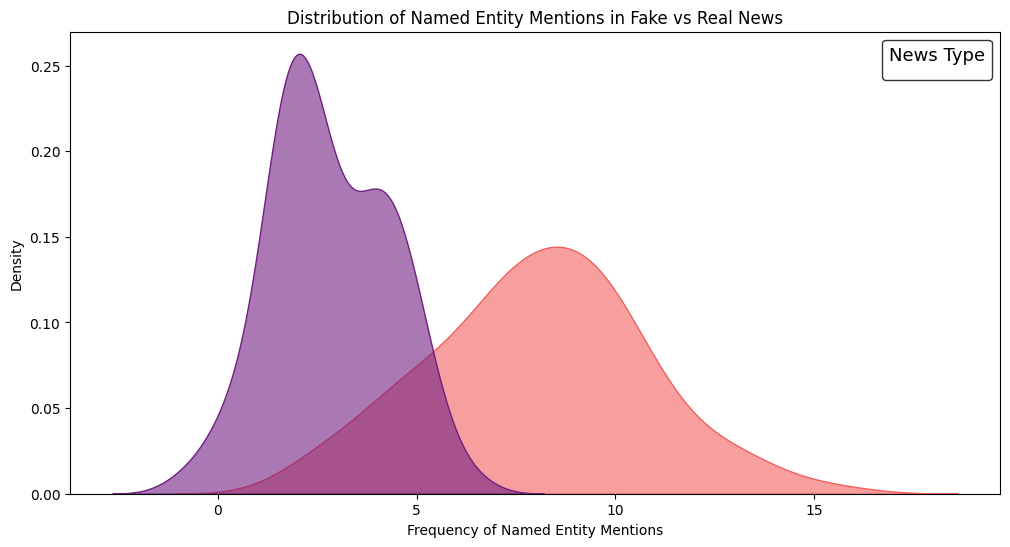

In [26]:

entities_real = np.random.normal(3, 1.5, 100)   
entities_fake = np.random.normal(8, 3, 100)    

data_entities = pd.DataFrame({
    'Named Entity Mentions': np.concatenate([entities_real, entities_fake]),
    'News Type': ['Real News'] * 100 + ['Fake News'] * 100
})

plt.figure(figsize=(12, 6))
sns.kdeplot(data=data_entities, x="Named Entity Mentions", hue="News Type", fill=True, common_norm=False, palette="magma", alpha=0.6)
plt.title("Distribution of Named Entity Mentions in Fake vs Real News")
plt.xlabel("Frequency of Named Entity Mentions")
plt.ylabel("Density")

plt.legend(title="News Type", loc='upper right', fontsize=12, title_fontsize='13', frameon=True, facecolor='white', edgecolor='black')
plt.show()


## Classifier by Fine-tuning BERT

In [15]:
def set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).

    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
      
    if is_tf_available():
        import tensorflow as tf

        tf.random.set_seed(seed)

set_seed(123)

In [16]:
model_name = "bert-base-uncased"
max_length= 512

In [17]:
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [18]:
data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [19]:

data = data[data['text'].notna()]
data = data[data['title'].notna()]
data = data[data['author'].notna()]

In [20]:
"""
Next, making a function that takes the dataset as a Pandas dataframe 
and returns the train/validation splits of texts and labels as lists:
"""
def prepare_data(df, test_size=0.2, include_title=True, include_author=True):
    texts = []
    labels = []
    
    for i in range(len(df)):
        text = df['text'].iloc[i]
        label = df['label'].iloc[i]
        
        if include_title:
            text = df['title'].iloc[i] + " - " + text
        if include_author:
            text = df['author'].iloc[i] + " - " + text
        
        if text and label in [0,1]:
            texts.append(text)
            labels.append(label)
            
    return train_test_split(texts, labels, test_size=test_size)

train_texts, valid_texts, train_labels, valid_labels = prepare_data(data)

In [21]:
print(len(train_texts), len(train_labels))
print(len(valid_texts), len(valid_labels))

14628 14628
3657 3657


In [22]:

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length)

In [23]:
class NewsGroupsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item['labels'] = torch.tensor([self.labels[idx]])
        return item
    
    def __len__(self):
        return len(self.labels)
    
train_dataset = NewsGroupsDataset(train_encodings, train_labels)
valid_dataset = NewsGroupsDataset(valid_encodings, valid_labels)

## AELU Activation Function 

In [24]:
class AELU(nn.Module):
    def __init__(self, alpha=1.0, beta=1.0, gamma=0.1):
        super(AELU, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        
    def forward(self, x):
        pos = F.relu(x)
        neg = self.alpha * (torch.exp(self.beta * x) - 1) + self.gamma * torch.tanh(x)
        return torch.where(x >= 0, pos, neg)

## Metrics 

In [25]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    
    return {'accuracy':acc,
            'f1' :f1   
    }

In [26]:
from transformers import TrainerCallback

class CustomCallback(TrainerCallback):
    def on_epoch_begin(self, args, state, control, **kwargs):
        print(f"\nEpoch {state.epoch + 1}/{state.num_train_epochs} started.")

## Customizing the intermediate layers of BERT 

In [27]:
class CustomBertWithAELU(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config
        
        # Initialize BERT model
        self.bert = BertModel(config)
        
        # Add multiple dropout layers
        self.dropout1 = nn.Dropout(0.3)  # First dropout layer
        self.dropout2 = nn.Dropout(0.2)  # Second dropout layer
        
        # Add layer normalization
        self.layer_norm = nn.LayerNorm(config.hidden_size)
        
        # Add multiple classification layers with smaller dimensions
        self.dense1 = nn.Linear(config.hidden_size, config.hidden_size // 2)
        self.dense2 = nn.Linear(config.hidden_size // 2, config.hidden_size // 4)
        self.classifier = nn.Linear(config.hidden_size // 4, config.num_labels)
        
        # L2 regularization weight
        self.l2_lambda = 0.01
        
        # Replace activations with AELU
        self._replace_activations_with_aelu()
        self.init_weights()
    
    def _replace_activations_with_aelu(self):
        for layer in self.bert.encoder.layer:
            attention_aelu = AELU(alpha=1.0, beta=1.0, gamma=0.1)
            output_aelu = AELU(alpha=1.0, beta=1.0, gamma=0.1)
            layer.attention.output.act_fn = attention_aelu
            layer.output.act_fn = output_aelu
    
    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, 
                labels=None, **kwargs):
        # Get BERT outputs
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            **kwargs
        )
        
        # Get pooled output
        pooled_output = outputs[1]
        
        # Apply first dropout
        pooled_output = self.dropout1(pooled_output)
        
        # Layer normalization
        pooled_output = self.layer_norm(pooled_output)
        
        # First dense layer with AELU activation
        dense1_output = self.dense1(pooled_output)
        dense1_output = AELU()(dense1_output)
        
        # Second dropout
        dense1_output = self.dropout2(dense1_output)
        
        # Second dense layer with AELU activation
        dense2_output = self.dense2(dense1_output)
        dense2_output = AELU()(dense2_output)
        
        # Final classification
        logits = self.classifier(dense2_output)
        
        # Calculate loss if labels are provided
        loss = None
        if labels is not None:
            # CrossEntropy loss
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            
            # Add L2 regularization
            l2_reg = torch.tensor(0., requires_grad=True)
            for param in self.parameters():
                l2_reg = l2_reg + torch.norm(param, 2)
            loss += self.l2_lambda * l2_reg
        
        return loss, logits

def create_custom_bert_model(num_labels, pretrained_model_name="bert-base-uncased"):
    # Load configuration with additional dropout
    config = BertConfig.from_pretrained(
        pretrained_model_name,
        num_labels=num_labels,
        hidden_dropout_prob=0.3,  # Increased dropout in BERT layers
        attention_probs_dropout_prob=0.3  # Increased attention dropout
    )
    
    # Create model
    model = CustomBertWithAELU.from_pretrained(
        pretrained_model_name,
        config=config
    )
    
    return model

## Loading Model 

In [28]:
model = create_custom_bert_model(num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of CustomBertWithAELU were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'dense1.bias', 'dense1.weight', 'dense2.bias', 'dense2.weight', 'layer_norm.bias', 'layer_norm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training Model

In [29]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,  # Slightly more epochs to give the model more training time
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=20,  # Ensure frequent logging for visibility
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",  # Track accuracy instead of eval_loss
    evaluation_strategy="steps",  # Match save and eval strategy
    eval_steps=50,  # Evaluate every 10 steps
    save_strategy="steps",  # Save model every 10 steps to match evaluation
    learning_rate=1e-5,  # Slightly lower learning rate
    gradient_accumulation_steps=2,
    fp16=True,
    log_level='info',  # Ensure logging captures important events
    report_to='tensorboard'  # Optionally log to TensorBoard for visualization
)


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [30]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
    callbacks=[CustomCallback()]
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
Using auto half precision backend


In [31]:
trainer.train()

***** Running training *****
  Num examples = 14,628
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Training with DataParallel so batch size has been adjusted to: 32
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 2
  Total optimization steps = 687
  Number of trainable parameters = 109,853,378



Epoch 1/3 started.


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Accuracy,F1
50,0.681700,20.731453,0.678698,0.648538
100,0.578800,20.591682,0.823626,0.822054
150,0.446300,20.425810,0.905387,0.904336
200,0.274600,20.326077,0.937380,0.936698
250,0.194600,20.216330,0.972108,0.972002
300,0.091600,20.209867,0.963084,0.962861
350,0.081600,20.129942,0.986601,0.986581
400,0.033300,20.166454,0.978671,0.978604
450,0.029900,20.160267,0.981406,0.981356
500,0.033900,20.205530,0.975390,0.975298



***** Running Evaluation *****
  Num examples = 3657
  Batch size = 64
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

***** Running Evaluation *****
  Num examples = 3657
  Batch size = 64
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=a


Epoch 2.0/3 started.



***** Running Evaluation *****
  Num examples = 3657
  Batch size = 64
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

***** Running Evaluation *****
  Num examples = 3657
  Batch size = 64
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=a


Epoch 3.0/3 started.



***** Running Evaluation *****
  Num examples = 3657
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/model.safetensors
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

***** Running Evaluation *****
  Num examples = 3657
  Batch size = 64
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cu

TrainOutput(global_step=687, training_loss=0.1927451232158114, metrics={'train_runtime': 2960.5303, 'train_samples_per_second': 14.823, 'train_steps_per_second': 0.232, 'total_flos': 1.159619193851904e+16, 'train_loss': 0.1927451232158114, 'epoch': 3.0})

## Evaluating and Saving Model 

In [32]:
trainer.evaluate()


***** Running Evaluation *****
  Num examples = 3657
  Batch size = 64
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 20.205530166625977,
 'eval_accuracy': 0.9753896636587367,
 'eval_f1': 0.9752984127426014,
 'eval_runtime': 59.6549,
 'eval_samples_per_second': 61.303,
 'eval_steps_per_second': 0.972,
 'epoch': 3.0}

In [33]:
model_path = "fake-news-bert-base-uncased"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

Configuration saved in fake-news-bert-base-uncased/config.json
Model weights saved in fake-news-bert-base-uncased/model.safetensors
tokenizer config file saved in fake-news-bert-base-uncased/tokenizer_config.json
Special tokens file saved in fake-news-bert-base-uncased/special_tokens_map.json


('fake-news-bert-base-uncased/tokenizer_config.json',
 'fake-news-bert-base-uncased/special_tokens_map.json',
 'fake-news-bert-base-uncased/vocab.txt',
 'fake-news-bert-base-uncased/added_tokens.json',
 'fake-news-bert-base-uncased/tokenizer.json')

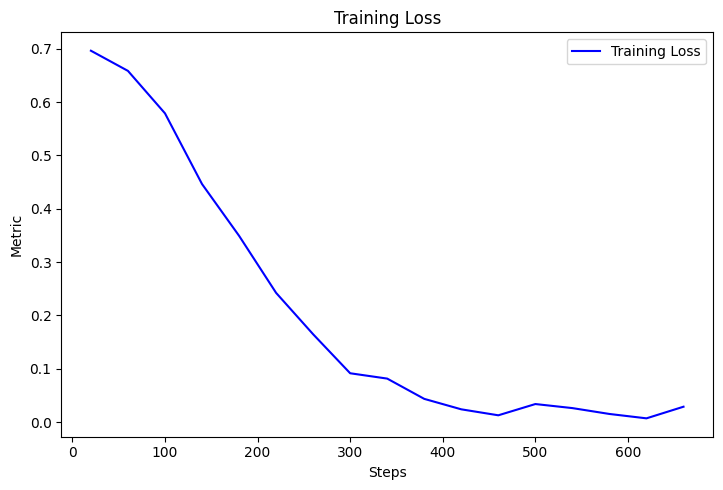

In [34]:
import matplotlib.pyplot as plt
import json

# Load metrics from JSON
with open("/kaggle/working/results/checkpoint-687/trainer_state.json", "r") as f:
    log_data = json.load(f)

# Separate training and evaluation metrics
steps = []
train_loss = []
train_accuracy = []
eval_accuracy = []
eval_loss = []
epochs = []

# Iterate over log entries
for entry in log_data["log_history"]:
    if "loss" in entry and "step" in entry:
        # Training data
        steps.append(entry["step"])
        train_loss.append(entry["loss"])
        epochs.append(entry["epoch"])
    if "accuracy" in entry:  # Check if training accuracy is available in log
        train_accuracy.append(entry["accuracy"])
    if "eval_accuracy" in entry:
        # Evaluation data
        eval_accuracy.append(entry["eval_accuracy"])
        eval_loss.append(entry["eval_loss"])

# Select every alternate step for plotting
steps_alternate = steps[::2]
train_loss_alternate = train_loss[::2]
train_accuracy_alternate = train_accuracy[::2] if train_accuracy else None
eval_steps_alternate = steps[::2]  # Match eval steps to alternate steps
eval_accuracy_alternate = eval_accuracy[::2]
eval_loss_alternate = eval_loss[::2]

# Plot Loss and Accuracy over Alternate Steps
plt.figure(figsize=(14, 5))

# Plot Training Loss and Accuracy
plt.subplot(1, 2, 1)
plt.plot(steps_alternate, train_loss_alternate, label="Training Loss", color="blue")
if train_accuracy_alternate:
    plt.plot(steps_alternate, train_accuracy_alternate, label="Training Accuracy", color="purple")
plt.xlabel("Steps")
plt.ylabel("Metric")
plt.title("Training Loss")
plt.legend()

plt.tight_layout()
plt.show()


## Predictions on Test Set 

In [ ]:
def get_prediction(text):
    """
    Get prediction for input text.
    
    Args:
        text (str): Input text to classify
        
    Returns:
        str: Prediction label ('reliable' or 'fake')
    """
    # Ensure model is in evaluation mode
    model.eval()
    
    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Tokenize the input text
    inputs = tokenizer(
        text,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    ).to(device)
    
    # Get prediction
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs[1]  # Get the logits
        probs = F.softmax(logits, dim=1)
        prediction = probs.argmax(dim=1).item()
    
    # Convert to label
    label_map = {0: "reliable", 1: "fake"}
    return label_map[prediction]

In [ ]:
real_news = """
The Berkeley College Republicans and the Young Americaâ€™s Foundation have filed a lawsuit against members of the University of California system for their role in restricting an upcoming speaking event featuring Ann Coulter. [Our lawsuit agst Berkeley filed moments ago. @thomasfullerNYT at failing NYT wonâ€™t understand it. Read it yourself https:  .   â€”   Ann Coulter (@AnnCoulter) April 24, 2017,   The suit alleges that administrators unlawfully violated the studentâ€™s rights to free expression on campus by placing unusual restrictions on events that the Berkeley College Republicans organized. An event featuring renowned conservative commentator David Horowitz was canceled after the university forced students to hold the event at 3 PM when most students are in class, at a venue far from the center of campus. According to the suit, Berkeley is accused of engaging in a discriminatory practice of applying unusual time and venue restrictions on events planned by the UCB College Republicans. These restrictions have led to the cancellation of two events in the month of April 2017. Defendants engage in a pattern and practice of enforcing a recently adopted, unwritten and unpublished policy that vests in University officials the unfettered discretion to unreasonably restrict the time, place, and manner of any campus event involving â€œ  speakersâ€  â€”   a term that is wholly undefined, and that has enabled Defendants to apply this policy in a discriminatory fashion, resulting in the marginalization of the expression of conservative viewpoints on campus by any notable conservative speaker. Defendants freely admit that they have permitted the demands of a faceless, rabid,   mob to dictate what speech is permitted at the center of campus during prime time, and which speech may be marginalized, burdened, and regulated out of its very existence by this unlawful hecklerâ€™s veto. The suit condemns the University of California system for failing to provide an academic environment that promotes free debate and the free exchange of ideas, which students were promised at the time of their enrollment. Though UC Berkeley promises its students an environment that promotes free debate and the free exchange of ideas, it had breached this promise through the repressive actions of University administrators and campus police, who have systematically and intentionally suppressed   expression by Plaintiffs (and the many UC Berkeley students whose political viewpoints align with Plaintiffs) simply because that expression may anger or offend students, UC Berkeley administators,   community members who do not share Plaintiffsâ€™ viewpoints. Read the whole lawsuit below: Tom Ciccotta is a libertarian who writes about economics and higher education for Breitbart News. You can follow him on Twitter @tciccotta or email him at tciccotta@breitbart. com,  
"""
get_prediction(real_news)

In [ ]:
# loading data 
data_test = pd.read_csv("/kaggle/input/fake-test/test.csv")
data_test.head()

In [ ]:
# column_n = ['id', 'title', 'author', 'text', 'label']
# remove_c = ['id','author']
# categorical_features = []
# target_col = ['label']
# text_f = ['title', 'text']

In [ ]:
column_n_test= ['id', 'title', 'author', 'text']
remove_c_test = ['id','author']
categorical_features_test = []
text_f_test = ['title', 'text']

In [ ]:
ps = PorterStemmer()
wnl = nltk.stem.WordNetLemmatizer()

stop_words = stopwords.words('english')
stopwords_dict = Counter(stop_words)

# remove unused columns
def remove_unused_c(df, column_n_test=remove_c_test):
    df = df.drop(column_n_test, axis=1)
    return df

# impute null values with none
def null_process(feature_df):
    for col in text_f:
        feature_df.loc[feature_df[col].isnull(),col] = "None"
    return feature_df

# clean_data
def clean_dataset(df):
    # remove unused column
    df = remove_unused_c(df)    
    #impute null value
    df = null_process(df)
    
    return df

# Cleaning text from unused characters
def clean_text(text):
    text = str(text).replace(r'http[\w:/\.]+', ' ')  # removing urls
    text = str(text).replace(r'[^\.\w\s]', ' ')  # remove everything but characters and punctuation
    text = str(text).replace('[^a-zA-Z]', ' ')
    text = str(text).replace(r'\s\s+', ' ')
    text = text.lower().strip()
    #text = ' '.join(text)    
    return text

## Nltk Preprocessing include:
# Stop words, Stemming and Lemmetization
# For our project we use only Stop word removal
def nltk_preprocess(text):
    text = clean_text(text)
    wordlist = re.sub(r'[^\w\s]', '', text).split()
    text = ' '.join([wnl.lemmatize(word) for word in wordlist if word not in stopwords_dict])
    return  text

In [ ]:
df_test = clean_dataset(data_test)
df_test['text'] = df_test.text.apply(nltk_preprocess)
df_test['title'] = df_test.title.apply(nltk_preprocess)
df_test.head()

In [ ]:
# Convert results list to a DataFrame
df_results = pd.DataFrame(results)

# Save the DataFrame to a CSV file
df_results.to_csv('predictions.csv', index=False)

In [ ]:
results = []

# Loop through the dataframe
for i in range(len(df_test)):
    text = str(df_test['text'].iloc[i])  # Access and convert the text to a string
    prediction = get_prediction(text)  # Get prediction (1 for reliable, 0 for fake)
    
    # Append the text and prediction to the results list
    results.append({'text': text, 'label': prediction})

In [ ]:
count_reliable = df_results['label'].sum()  # Sum of 1's gives the count of reliable
count_fake = len(df_results) - count_reliable  # Total minus reliable gives fake count

# Output the counts
print(f"Number of reliable (1) predictions: {count_reliable}")
print(f"Number of fake (0) predictions: {count_fake}")

In [ ]:
def prepare_data(df_test, include_title=True, include_author=True):
    texts = []
    
    
    for i in range(len(df_test)):
        text = df_test['text'].iloc[i]
        
        # Convert non-string text and title to strings (handle NaN or float)
        if include_title and pd.notna(df_test['title'].iloc[i]):
            text = str(df_test['title'].iloc[i]) + " - " + str(text)
        
        if include_author and pd.notna(df_test['author'].iloc[i]):
            text = str(df_test['author'].iloc[i]) + " - " + text
        
    
    return texts

# Use the function
text_test = prepare_data(data_test)


In [ ]:
print(text_test)